In [10]:
import os
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from skimage.io import imread, imsave

# import torchvision.transforms.functional
import torchvision.transforms.functional as F

from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torch.nn as nn

from torchinfo import summary
from tqdm import tqdm

In [2]:
from Multilabel_Amazon_Module import AmazonSpaces
import Multilabel_Amazon_Engine

In [3]:
class AmazonSpacesOld(Dataset):
    """Amazon aerial image dataset."""

    def __init__(self, csv_file, root_dir, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with labels.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.labels = pd.read_csv(csv_file)

        self.tags = self.labels['tags'].str.split(expand=True).stack().unique()
        for tag in self.tags:
            a = [(tag in i.split()) for i in self.labels['tags']]
            self.labels[tag] = np.zeros(len(a), dtype=int) + a

        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return self.labels.shape[0]

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = os.path.join(self.root_dir,
                                self.labels['image_name'].iloc[idx])
        img_name = f'{img_name}.jpg'
        image = imread(img_name)
        #image = torch.from_numpy(image)

        if self.transform:
            image = self.transform(image)

        labels = self.labels.loc[idx, self.tags].to_numpy(dtype=np.float64)
        #labels = torch.from_numpy(labels)
        #other output
        sample = {'image': image, 'labels': labels}

        #print(type(image), type(labels))
        return sample


In [4]:
data_folder = '../IPEO_Planet_project'
if not os.path.exists(data_folder):
    data_folder = input("Enter the data folder path: ")
    assert os.path.exists(data_folder), "I did not find the folder at, "+str(data_folder)

Transform_choice = transforms.Compose([transforms.ToTensor(), transforms.CenterCrop(256)])

Amazon_Old_Dataset = AmazonSpacesOld(csv_file=f'{data_folder}/train_labels.csv',
                              root_dir=f'{data_folder}/train-jpg')
Amazon_New_Dataset = AmazonSpaces(csv_file=f'{data_folder}/train_labels.csv',
                                    root_dir=f'{data_folder}/train-jpg', transform=Transform_choice)

In [7]:
labels_dt = pd.read_csv(f'{data_folder}/train_labels.csv',dtype=str)
tags = pd.Series(labels_dt['tags'].str.split(expand=True).stack().unique())
tags

0                  haze
1               primary
2           agriculture
3                 clear
4                 water
5            habitation
6                  road
7           cultivation
8            slash_burn
9                cloudy
10        partly_cloudy
11    conventional_mine
12          bare_ground
13       artisinal_mine
14             blooming
15    selective_logging
16            blow_down
dtype: object

[164 229 151 813]
164
229
151
813


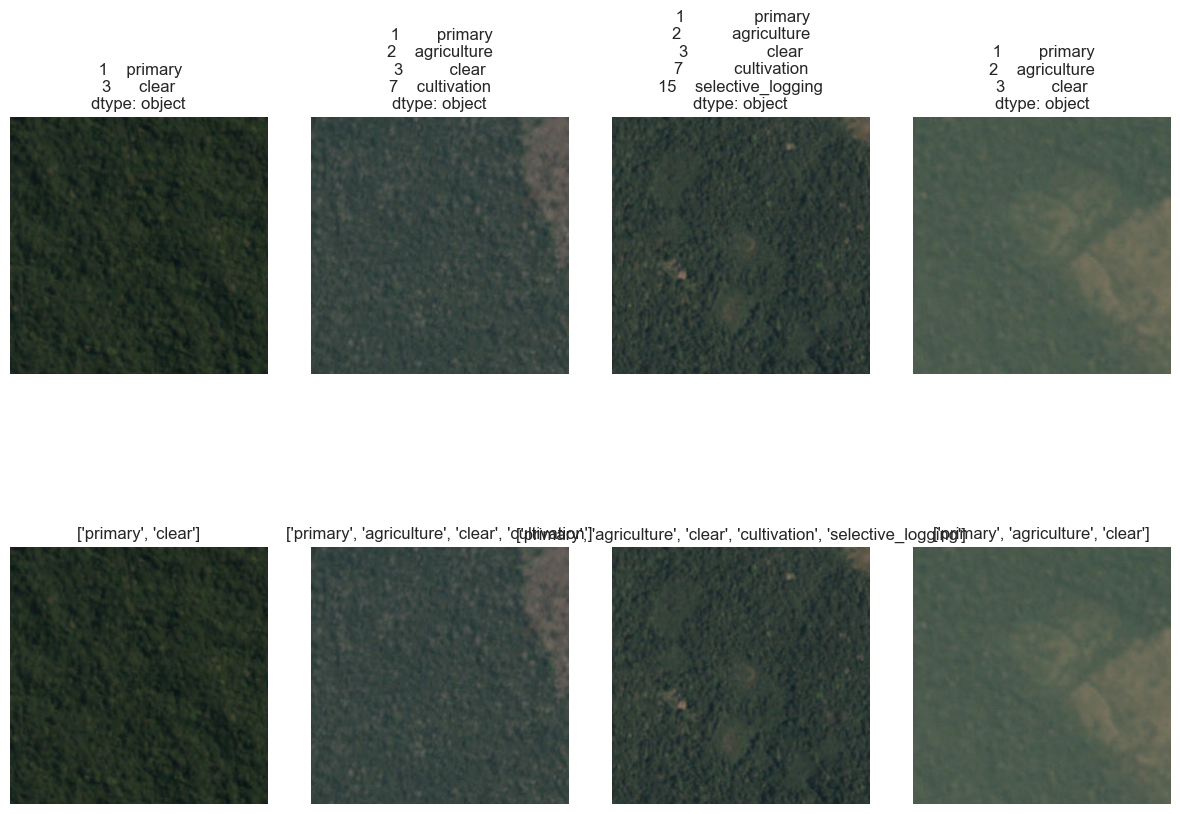

In [29]:
plt.figure(figsize=(12,10))
N=4

tags2 =['haze', 'primary', 'agriculture', 'clear', 'water', 'habitation', 'road', 'cultivation', 'slash_burn', 'cloudy', 'partly_cloudy', 'conventional_mine', 'bare_ground', 'artisinal_mine', 'blooming', 'selective_logging', 'blow_down']
num_tags = np.arange(start=0, stop=len(tags2))

listImage = np.random.rand(4)*1000
listImage = listImage.astype(np.int32)
print(listImage)
count = 0
for i in listImage:
    print(i)
    #Image from original direct dataset
    #image, labels = Amazon_dataset[i]

    sample = Amazon_Old_Dataset[i]
    labels = sample['labels']
    image = sample['image']


    ax = plt.subplot(2, 4, count + 1)
    plt.tight_layout()
    ax.set_title(f' {tags[labels==1]}')
    ax.axis('off')
    img = F.to_pil_image(image)
    ax.imshow(img)

    #Images from transformed_dataset

    sample_tf = Amazon_New_Dataset[i]
    labels_tf = sample_tf['labels']
    image_tf = sample_tf['image']

    ax = plt.subplot(2, 4, count + 5)
    plt.tight_layout()
    ids = num_tags[labels_tf == 1.0]
    names = [tags[ix] for ix in ids]
    ax.set_title(f'{names}')
    ax.axis('off')
    img = F.to_pil_image(image_tf)
    ax.imshow(img)
    count = count + 1

plt.show()